In [1]:

import pandas
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import torch 
import torchvision 
import torchvision.transforms as transforms 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from tqdm import tqdm


In [2]:
import os

photos_x10, labels_x10 = [], []
photos_x40, labels_x40 = [], []

# directory = os.path.join('/content/drive/MyDrive' ,'H9p36/H9p36')
directory = './H9p36'
files = os.listdir(directory)
for file in files:
  filename = file.split('.')
  if filename[1] == 'png':
    picture = filename[0].split('_')
    if len(picture) != 1:
      picture_scale = picture[0].split('x')
      if len(picture_scale) == 1:
        photos_x10.append(picture_scale[0])
        labels_x10.append(picture[1])
      else:
        photos_x40.append(file)
        labels_x40.append(picture[1])
        

In [4]:
len(photos_x40)

269

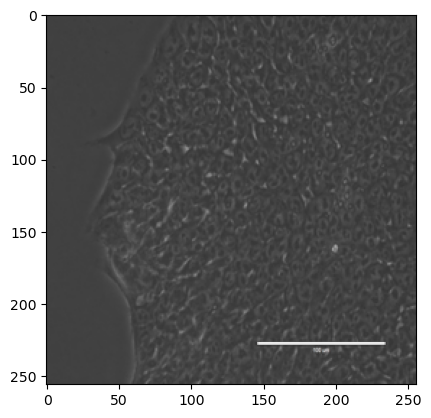

In [5]:
from PIL import Image
from skimage.color import rgba2rgb

def resize(dataset):
  resize_images = []
  for data in dataset:
    image = Image.open(os.path.join(directory, data))
    image = image.resize((256, 256), Image.LANCZOS)
    image = np.array(image)

    if image.shape != (256, 256, 3):
      image = rgba2rgb(image)

    resize_images.append(image)
  return resize_images

resize_photos_x40 = resize(photos_x40)
plt.imshow(resize_photos_x40[-1])

In [6]:
# ## Histogram equalization

# In[6]:


from skimage.util import img_as_ubyte
from skimage import exposure

equalize_photos_x40 = []

for i in resize_photos_x40:
  img = img_as_ubyte(i)
  img_rescale = exposure.equalize_hist(img)
  equalize_photos_x40.append(img_rescale)


/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [7]:
# ## Convert to GrayScale

# In[7]:


from skimage.color import rgb2gray

def GrayScale(dataset):
  gray_img = []
  for img in dataset:
    gray = rgb2gray(img)
    gray = np.expand_dims(gray, axis=2)
    gray_img.append(gray)
  return gray_img

gray_photos_x40 = GrayScale(resize_photos_x40)



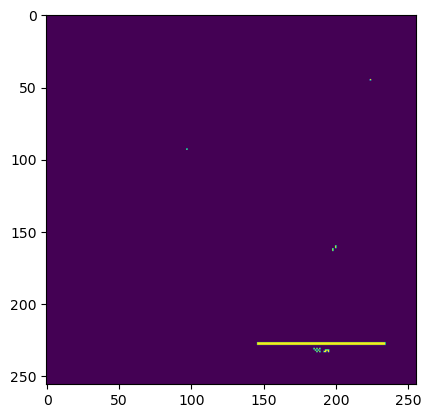

In [8]:
# ## Binarization

# In[8]:


from skimage.filters import threshold_otsu

otsu_photos_x40 = []

for i in gray_photos_x40:
  thresh = threshold_otsu(i)
  binary = i > thresh
  otsu_photos_x40.append(binary)


# In[9]:


plt.imshow(otsu_photos_x40[-1])

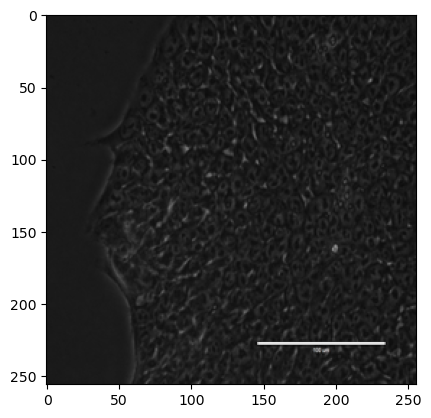

In [9]:
# ## Normalization of images

# In[10]:


min_ = []
max_ = []

for photo in resize_photos_x40:
  _max = 0
  _min = 9999
  for i in photo:
    for j in i:
      for k in j:
        if k < _min:
          _min = k
        if k > _max:
          _max = k
  min_.append(_min)
  max_.append(_max)


import copy

def my_normalize1(resize_photos_x40, min_, max_):
  my = copy.deepcopy(resize_photos_x40)
  for photo_id, (photo, _min, _max) in enumerate(zip(resize_photos_x40, min_, max_)):
      my[photo_id] = (photo - _min) / (_max -_min)
  return my

normalize_photos_x40 = my_normalize1(resize_photos_x40, min_, max_)


# In[11]:


plt.imshow(normalize_photos_x40[-1])

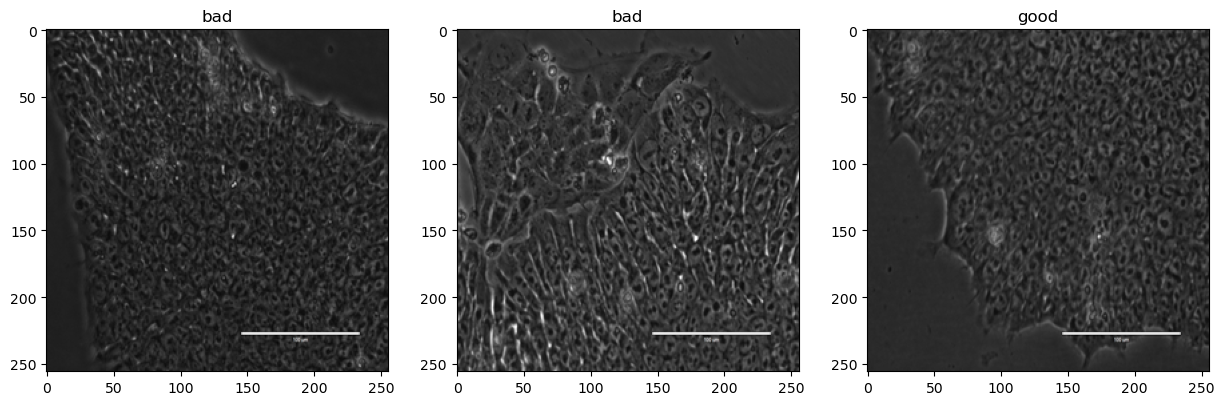

In [10]:
# ## Draw labeled images

# In[12]:


def beautiful_show_images(dataset, labels, necessary_count):
  fig, axes = plt.subplots(1, necessary_count, figsize = (15, 15))
  plt.gray()

  for i in range(necessary_count):
    tmp = np.random.randint(1, len(dataset))

    axes[i].imshow(dataset[tmp])
    axes[i].set_title(labels[tmp])

beautiful_show_images(normalize_photos_x40, labels_x40, 3)



In [11]:
# ## Split data into training and validation sets
# 
# 

# In[22]:


from sklearn.model_selection import train_test_split

def train_val_split(dataset, labels):
  X_train, X_val, y_train, y_val = train_test_split(dataset, labels, test_size=0.2, random_state=1)

  X = {"train":np.array(X_train), "val":np.array(X_val)}
  Labels = {"train":np.array(y_train), "val":np.array(y_val)}
  
  return X, Labels

X, Labels = train_val_split(photos_x40, labels_x40)
#X, Labels = train_val_split(equalize_photos_x40, labels_x40)



In [12]:
# ## Wrap data by DataLoader

# In[23]:


from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torchvision import datasets
from PIL import Image
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from skimage import exposure


from skimage.io import imread

import albumentations as A

class ClassificationDataSet(Dataset):
    def __init__(self, inputs: list, labels, transform=None, phase='train'):
        transform1 = A.Compose([
          A.RandomCrop(width=256, height=256),
          A.HorizontalFlip(p=0.5),
          A.Transpose(p=0.5),
          A.VerticalFlip(p=0.5),
        ])
        transform2 = A.Compose([
           A.CenterCrop(width=256, height=256)                     
        ])
        self.inputs = inputs
        self.labels = labels
        self.transform = None
        self.inputs_dtype = torch.float
        self.targets_dtype = torch.float
        self.phase = phase
        if self.phase == 'train':
          self.transform =  transform1
        if self.phase == 'val':
          self.transform =  transform2

    def augmentation(self, x):
      return self.transform(image = x)["image"]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index: int):
        input_ID = self.inputs[index]
        x = Image.open(os.path.join(directory, input_ID))   

        if self.transform:
          x = x.resize((512, 512), Image.LANCZOS)
          #x = x.resize((256, 256), Image.LANCZOS)
          x = np.array(x)

          x  = self.augmentation(x)
        else:
          x = x.resize((256, 256), Image.LANCZOS)
          x = np.array(x)


        img = img_as_ubyte(x)
        x = exposure.equalize_hist(img)
        x = rgb2gray(x)
        x = np.expand_dims(x, axis=2)
        x = x.astype(float)

        y = self.labels[index]
        y = torch.from_numpy(np.array(y).astype(float))
        y = y.type(torch.float)

        return torch.from_numpy(x).type(torch.float).permute(2,0,1), y

batch_size = 64
num_workers = 0

for key in Labels:
  Labels[key][Labels[key]=='good'] = 1
  Labels[key][Labels[key]=='bad'] = 0

trainset = ClassificationDataSet(X['train'], Labels['train'], transform=True, phase='train')
valset = ClassificationDataSet(X['val'], Labels['val'], transform=True, phase='val')

dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val': torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }

In [13]:
# ## CNN VGG13 Implementation

# In[24]:


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' VGG13 convolutional neural network'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=1, out_channels=thickness)
        self.conv2 = conv3x3(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv12 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)    # 16 256 256
        x = self.conv2(x)          

        x = self.conv3(x)   # 32  128 128
        x = self.conv4(x)   

        x = self.conv5(x)   # 64  64 64
        x = self.conv6(x) 

        x = self.conv7(x)   # 128 32 32
        x = self.conv8(x)   

        x = self.conv9(x) # 128 16 16
        x = self.conv10(x)

        x = self.conv11(x) # 128 8 8
        x = self.conv12(x) # 128 4 4

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)


In [14]:
# ## VGG12

# In[20]:


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    '''VGG12 convolutional neural network'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness)
        self.conv2 = conv3x3(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)    # 16 256 256
        x = self.conv2(x)          

        x = self.conv3(x)   # 32  128 128
        x = self.conv4(x)   

        x = self.conv5(x)   # 64  64 64
        x = self.conv6(x) 

        x = self.conv7(x)   # 128 32 32
        x = self.conv8(x)   

        x = self.conv9(x) # 128 16 16
        x = self.conv10(x)

        x = self.conv11(x) # 128 8 8
        
        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net()
net = net.to(device=device)

In [15]:
# ## VGG12-Pool4

# In[21]:


def conv3x3_maxpool4(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' VGG12-Pool4 convolutional neural network'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 2 * 2, 1)

    def forward(self, x):
        x = self.conv1(x)   # 16 256 256
        x = self.conv2(x)   # 16 64 64 

        x = self.conv3(x)   # 32 64 64
        x = self.conv4(x)   # 32 32 32 

        x = self.conv5(x)   # 64 32 32
        x = self.conv6(x)   # 64 16 16

        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x)   # 128 8 8

        x = self.conv9(x)   # 128 8 8
        x = self.conv10(x)  # 128 4 4

        x = self.conv11(x)  # 128 4 4

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)


In [16]:
# ## Model with Skip Сonnection

# In[22]:


from torch.nn.modules.conv import Conv2d
def conv3x3(in_channels, out_channels, rel=False, batch=False, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
    ]

    if rel:
        layers.append(nn.PReLU(out_channels))

    if batch:
        layers.append(nn.BatchNorm2d(out_channels))

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)

class Net(nn.Module):
    ''' CNN with skip connection'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness, rel=True, batch=True)
        self.conv2 = conv3x3(in_channels=thickness, out_channels=thickness, batch=True, pool=True)
        self.conv_identity1 = Conv2d(in_channels=3, out_channels=thickness, kernel_size=(1, 1), stride=2)
        self.batch1 = nn.BatchNorm2d(thickness)
        self.relu1 = nn.PReLU(thickness)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2, rel=True, batch=True)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, batch=True, pool=True)
        self.conv_identity2 = Conv2d(in_channels=thickness, out_channels=thickness*2, kernel_size=(1, 1), stride=2)
        self.batch2 = nn.BatchNorm2d(thickness*2)
        self.relu2 = nn.PReLU(thickness*2)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4, rel=True, batch=True)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, batch=True, pool=True)
        self.conv_identity3 = Conv2d(in_channels=thickness*2, out_channels=thickness*4, kernel_size=(1, 1), stride=2)
        self.batch3 = nn.BatchNorm2d(thickness*4)
        self.relu3 = nn.PReLU(thickness*4)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8, rel=True, batch=True)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, batch=True, pool=True)
        self.conv_identity4 = Conv2d(in_channels=thickness*4, out_channels=thickness*8, kernel_size=(1, 1), stride=2)
        self.batch4 = nn.BatchNorm2d(thickness*8)
        self.relu4 = nn.PReLU(thickness*8)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, rel=True, batch=True)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, batch=True)
        self.batch5 = nn.BatchNorm2d(thickness*8)
        self.relu5 = nn.PReLU(thickness*8)
      
        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, rel=True, batch=True)
        self.conv12 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, batch=True)
        self.batch6 = nn.BatchNorm2d(thickness*8)
        self.relu6 = nn.PReLU(thickness*8)
	      
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=32)

        self.rel = nn.PReLU()

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        a = x
        x = self.conv1(x)    # 16 256 256
        x = self.conv2(x) 
        y = self.conv_identity1(a)
        x = y + x
        x = self.relu1(x)
        x = self.batch1(x)
        

        a = x         
        x = self.conv3(x)   # 32  128 128
        x = self.conv4(x)
        y = self.conv_identity2(a)
        x = y + x
        x = self.relu2(x)
        x = self.batch2(x)
   

        a = x
        x = self.conv5(x)   # 64  64 64
        x = self.conv6(x) 
        y = self.conv_identity3(a)
        x = y + x
        x = self.relu3(x)
        x = self.batch3(x)

        a = x
        x = self.conv7(x)   # 128 32 32
        x = self.conv8(x) 
        y = self.conv_identity4(a)
        x = y + x
        x = self.relu4(x)
        x = self.batch4(x)

        a = x
        x = self.conv9(x) # 128 16 16
        x = self.conv10(x)
        x = x + a
        x = self.maxpool(x)
        x = self.relu5(x)
        x = self.batch5(x)

        a = x
        x = self.conv11(x) # 128 8 8
        x = self.conv12(x) # 128 4 4
        x = x + a
        x = self.maxpool(x)
        x = self.relu6(x)
        x = self.batch6(x)

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)

In [17]:
# ## Model with maxpool4*4 Skip Connection

# In[23]:


from torch.nn.modules.conv import Conv2d

def conv3x3_maxpool4(in_channels, out_channels, rel=False, batch=False, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
    ]

    if rel:
        layers.append(nn.PReLU())

    if batch:
        layers.append(nn.BatchNorm2d(out_channels))

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, rel=False, batch=False, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
    ]

    if rel:
        layers.append(nn.PReLU())

    if batch:
        layers.append(nn.BatchNorm2d(out_channels))

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)

class Net(nn.Module):
    ''' Model with maxpool4*4 Skip Connection'''
	
    def __init__(self, thickness=16):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=1, out_channels=thickness, rel=True, batch=True)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)
        self.conv_identity1 = Conv2d(in_channels=1, out_channels=thickness, kernel_size=(1, 1), stride=4)
        self.batch1 = nn.BatchNorm2d(thickness)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2, rel=True, batch=True)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)
        self.conv_identity2 = Conv2d(in_channels=thickness, out_channels=thickness*2, kernel_size=(1, 1), stride=2)
        self.batch2 = nn.BatchNorm2d(thickness*2)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4, rel=True, batch=True)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)
        self.conv_identity3 = Conv2d(in_channels=thickness*2, out_channels=thickness*4, kernel_size=(1, 1), stride=2)
        self.batch3 = nn.BatchNorm2d(thickness*4)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8, rel=True, batch=True)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)
        self.conv_identity4 = Conv2d(in_channels=thickness*4, out_channels=thickness*8, kernel_size=(1, 1), stride=2)
        self.batch4 = nn.BatchNorm2d(thickness*8)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, rel=True, batch=True)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.batch5 = nn.BatchNorm2d(thickness*8)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, rel=True, batch=True)
        self.conv12 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.batch6 = nn.BatchNorm2d(thickness*8)
	      
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.rel = nn.PReLU()

        self.fc1 = nn.Linear(thickness * 8 * 2 * 2, 1)

    def forward(self, x):
        a = x
        x = self.conv1(x)    # 16 256 256
        x = self.conv2(x) 
        y = self.conv_identity1(a)
        x = y + x
        x = self.rel(x)
        x = self.batch1(x)
        

        a = x         
        x = self.conv3(x)   # 32  64  64
        x = self.conv4(x)
        y = self.conv_identity2(a)
        x = y + x
        x = self.rel(x)
        x = self.batch2(x)
   

        a = x
        x = self.conv5(x)   # 64  32 32
        x = self.conv6(x) 
        y = self.conv_identity3(a)
        x = y + x
        x = self.rel(x)
        x = self.batch3(x)

        a = x
        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x) 
        y = self.conv_identity4(a)
        x = y + x
        x = self.rel(x)
        x = self.batch4(x)

        a = x
        x = self.conv9(x) # 128 8 8
        x = self.conv10(x)
        x = x + a
        x = self.maxpool(x)
        x = self.rel(x)
        x = self.batch5(x)

        a = x
        x = self.conv11(x) # 128 8 8
        x = self.conv12(x) # 128 4 4
        x = x + a
        x = self.maxpool(x)
        x = self.rel(x)
        x = self.batch6(x)


        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)

In [18]:
# ## CNN implementation with maxpool 4*4 in the first layer

# In[24]:


def conv3x3_maxpool4(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' CNN implementation with maxpool 4*4 in the first layer'''
	
    def __init__(self, thickness=4):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv12 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 2 * 2, 1)

    def forward(self, x):
        x = self.conv1(x)   # 16 256 256
        x = self.conv2(x)   # 16 64 64 

        x = self.conv3(x)   # 32 64 64
        x = self.conv4(x)   # 32 32 32 

        x = self.conv5(x)   # 64 32 32
        x = self.conv6(x)   # 64 16 16

        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x)   # 128 8 8

        x = self.conv9(x)   # 128 8 8
        x = self.conv10(x)  # 128 4 4

        x = self.conv11(x)  # 128 4 4
        x = self.conv12(x)  # 128 2 2

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(4)
net = net.to(device=device)


In [19]:

# ## CNN implementation with maxpool and without last layer

# In[25]:


def conv3x3_maxpool4(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' CNN implementation with maxpool and without last layer'''
	
    def __init__(self, thickness=16):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=3, out_channels=thickness)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv11 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)   # 16 256 256
        x = self.conv2(x)   # 16 64 64 

        x = self.conv3(x)   # 32 64 64
        x = self.conv4(x)   # 32 32 32 

        x = self.conv5(x)   # 64 32 32
        x = self.conv6(x)   # 64 16 16

        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x)   # 128 8 8

        x = self.conv9(x)   # 128 8 8
        x = self.conv10(x)  # 128 4 4

        x = self.conv11(x)  # 128 4 4

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(8)
net = net.to(device=device)
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool

In [20]:

# ## CNN implementation without two last conv

# In[26]:


def conv3x3_maxpool4(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((4, 4)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


def conv3x3(in_channels, out_channels, pool=False, dropout=None):
    layers = [
        nn.Conv2d(in_channels, out_channels, (3, 3), padding=1),
        nn.PReLU(),
        nn.BatchNorm2d(out_channels),
    ]

    if pool:
        layers.append(nn.MaxPool2d((2, 2)))

    if dropout is not None:
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)


class Net(nn.Module):
    ''' CNN implementation without two last conv'''
	
    def __init__(self, thickness=16):

        super(Net, self).__init__()
        self.conv1 = conv3x3(in_channels=1, out_channels=thickness)
        self.conv2 = conv3x3_maxpool4(in_channels=thickness, out_channels=thickness, pool=True)

        self.conv3 = conv3x3(in_channels=thickness, out_channels=thickness*2)
        self.conv4 = conv3x3(in_channels=thickness*2, out_channels=thickness*2, pool=True)

        self.conv5 = conv3x3(in_channels=thickness*2, out_channels=thickness*4)
        self.conv6 = conv3x3(in_channels=thickness*4, out_channels=thickness*4, pool=True)

        self.conv7 = conv3x3(in_channels=thickness*4, out_channels=thickness*8)
        self.conv8 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.conv9 = conv3x3(in_channels=thickness*8, out_channels=thickness*8)
        self.conv10 = conv3x3(in_channels=thickness*8, out_channels=thickness*8, pool=True)

        self.fc1 = nn.Linear(thickness * 8 * 4 * 4, 1)

    def forward(self, x):
        x = self.conv1(x)   # 16 256 256
        x = self.conv2(x)   # 16 64 64 

        x = self.conv3(x)   # 32 64 64
        x = self.conv4(x)   # 32 32 32 

        x = self.conv5(x)   # 64 32 32
        x = self.conv6(x)   # 64 16 16

        x = self.conv7(x)   # 128 16 16
        x = self.conv8(x)   # 128 8 8

        x = self.conv9(x)   # 128 8 8
        x = self.conv10(x)  # 128 4 4

        x = x.reshape(x.shape[0], -1)

        x = self.fc1(x)
        return torch.sigmoid(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #training with either cpu or cuda
net = Net(8)
net = net.to(device=device)
print(net)


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool

In [21]:

# ## Loss function and optimizer definition

# In[25]:


from torch.optim.lr_scheduler import ReduceLROnPlateau
'''
optim.SGD → implemets stochastic gradient descent
net.parameters() → gets CNN parameters
lr → learning rate of gradient descent
momentum → speedup gradient vectors in needed direction
'''
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())
scheduler = ReduceLROnPlateau(optimizer, 'min')



In [22]:
# ## Plot learning curves

# In[26]:


import plotly.express as px
import plotly.graph_objects as go

def create_plots1(epochs_train, epochs_valid, epoch_valid_metrics):
  t = np.linspace(1, len(epochs_train), len(epochs_train))
  x_rev = t[::-1]
  
  valid_scores_mean = np.mean(epochs_valid)
  valid_scores_std = np.std(epochs_valid)
  train_scores_mean = np.mean(epochs_train)
  train_scores_std = np.std(epochs_train)

  ci_valid = []
  ci_train = []

  for i in range(len(epochs_valid)):
    ci_valid.append(epochs_valid[i] * valid_scores_std / valid_scores_mean)
    ci_train.append(epochs_valid[i] * train_scores_std / train_scores_mean)

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=t, y=epochs_valid,
                      mode='lines+markers',
                      name='Validation'))
  
  fig.add_trace(go.Scatter(x=t, y=epochs_train,
                      mode='lines+markers',
                      name='Training'))

  y_u_valid = []
  y_l_valid = []

  for i in range(len(epochs_valid)):
    y_u_valid.append(epochs_valid[i] + ci_valid[i])
    y_l_valid.append(epochs_valid[i] - ci_valid[i])
  y_l_valid = y_l_valid[::-1]

  fig.add_trace(go.Scatter(
    x=np.concatenate([t, x_rev]),
    y=np.concatenate([y_u_valid, y_l_valid]),
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)', 
  ))

  y_u_train = []
  y_l_train = []

  for i in range(len(epochs_train)):
    y_u_train.append(epochs_train[i] + ci_train[i])
    y_l_train.append(epochs_train[i] - ci_train[i])
  y_l_train = y_l_train[::-1]

  fig.add_trace(go.Scatter(
    x=np.concatenate([t, x_rev]),
    y=np.concatenate([y_u_train, y_l_train]),
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line_color='rgba(255,255,255,0)', 
  ))

  fig.update_layout(legend_title_text = "Phase")
  fig.update_xaxes(title_text="Epochs")
  fig.update_yaxes(title_text="Value")
  fig.show()

In [23]:
# In[27]:


import plotly.express as px
import plotly.graph_objects as go

def create_plots(epochs_train,epochs_valid, epoch_valid_metrics):
  t = np.linspace(1, len(epochs_train), len(epochs_train))
  x_rev = t[::-1]
  
  valid_scores_mean = np.mean(epochs_valid)
  valid_scores_std = np.std(epochs_valid)
  train_scores_mean = np.mean(epochs_train)
  train_scores_std = np.std(epochs_train)

  ci_valid = 0.05 * valid_scores_std / valid_scores_mean
  ci_train = 0.05 * train_scores_std / train_scores_mean

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=t, y=epochs_valid,
                      mode='lines+markers',
                      name='Validation'))
  
  fig.update_traces(mode='lines')
  
  fig.add_trace(go.Scatter(x=t, y=epochs_train,
                      mode='lines+markers',
                      name='Training'))

  y_u = epochs_valid + ci_valid
  y_l = epochs_valid - ci_valid
  y_l = y_l[::-1]

  fig.add_trace(go.Scatter(
    x=np.concatenate([t, x_rev]),
    y=np.concatenate([y_u, y_l]),
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)', 
  ))

  fig.update_layout(legend_title_text = "Phase")
  fig.update_xaxes(title_text="Epochs")
  fig.update_yaxes(type="log", title_text="Log(Value)")

  fig.show()


  fig = go.Figure()
  fig.add_trace(go.Scatter(x=t, y=epochs_valid,
                      mode='lines+markers',
                      name='Validation'))
  
  fig.add_trace(go.Scatter(x=t, y=epochs_train,
                      mode='lines+markers',
                      name='Training'))
  
  fig.update_layout(legend_title_text = "Phase")
  fig.update_xaxes(title_text="Epochs")
  fig.update_yaxes(title_text="Value")
  fig.show()


  fig = go.Figure()
  fig.add_trace(go.Scatter(x=t, y=epoch_valid_metrics['Accuracy'],
                      mode='lines+markers',
                      name='Accuracy'))

  fig.add_trace(go.Scatter(x=t, y=epoch_valid_metrics['Precision'],
                      mode='lines+markers',
                      name='Precision'))
  
  fig.add_trace(go.Scatter(x=t, y=epoch_valid_metrics['Recall'],
                      mode='lines+markers',
                      name='Recall'))
                      
  fig.add_trace(go.Scatter(x=t, y=epoch_valid_metrics['F1'],
                    mode='lines+markers',
                    name='F1'))
  
  fig.update_layout(legend_title_text = "Metrics")
  fig.update_xaxes(title_text="Epochs")
  fig.update_yaxes(title_text="Value")

  fig.show()

In [24]:
# ## Save best model parameters to text file

# In[28]:


# model_directory = os.path.join('/content/drive/MyDrive' ,'Experiments/2')
model_directory = './Experiments/VGG13_histeq_tff'

def write_metrics_in_file(epochs_train, epochs_valid, epoch_valid_metrics):
  print(epochs_train)
  print()
  print(epochs_valid)
  print()
  print(epoch_valid_metrics)
  
  with open(os.path.join(model_directory, "epochs_valid_metrics.txt"), 'a') as file:
    file.write(f"{epoch_valid_metrics['Accuracy'][-1]} {epoch_valid_metrics['Precision'][-1]} {epoch_valid_metrics['Recall'][-1]} {epoch_valid_metrics['F1'][-1]} \n")
  
  with open(os.path.join(model_directory, "epochs_valid.txt"), 'a') as f:
    f.write(f"{epochs_valid[-1]} \n")
  with open(os.path.join(model_directory, "epochs_train.txt"), 'a') as f:
    f.write(f"{epochs_train[-1]} \n")
  


In [25]:
# ## CNN training

# In[29]:


from sklearn.metrics import confusion_matrix
from collections import defaultdict
from torch.nn.functional import normalize

epochs = 20
border = 0.7
best_F_score = 0
phases = ['train', 'val']

epochs_valid = []
epoch_valid_metrics = defaultdict(list)
epochs_train = []
for epoch in range(epochs):  # multiple walk through dataset
    loss_train = []
    loss_valid = []
    for phase in phases:
      running_loss = 0.0
      prediction = []
      label = [] 

      for i, data in tqdm(enumerate(dataloaders[phase]), total = len(dataloaders[phase])):
          # get input data as list [inputs, labels]
          inputs, labels = data
          print(inputs.shape)
          # raise Exception
          #img = inputs[0].permute(1,2,0).numpy()
          #plt.imshow(img.astype(int))
          #plt.show()
          #inputs = normalize(inputs, p=2.0, dim = 0)
          #img = 255 * inputs[0].permute(1,2,0).numpy()
          #plt.imshow(img.astype(int))
          #plt.show()
          #raise Exception

          inputs, labels = inputs.to(device), labels.to(device)

          # zero gradient parameters
          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == "train"):
            outputs = net(inputs.float())
            loss = criterion(outputs.flatten(), labels)
            if phase == 'train':
              loss.backward()
              optimizer.step()
              loss_train.append(loss.item())
            if phase == 'val':
              loss_valid.append(loss.item())
              res = outputs.detach().cpu().numpy() 
              res = res > border
              res  = res.astype(int)
              res = res.squeeze()
              prediction.extend(res)
              labels = labels.detach().cpu().numpy()
              label.extend(labels)
            if i % 5 == 0:
              tqdm.write(f"Epochs[{epoch+1}/{epochs}], phase:{phase}")
            running_loss = 0.0

      if phase == 'train':
        epochs_train.append(np.mean(loss_train))


      if phase == "val":
          epochs_valid.append(np.mean(loss_valid))


          conf_mtrx = confusion_matrix(label, prediction)
          accuracy = (conf_mtrx[0, 0] + conf_mtrx[1, 1]) / (conf_mtrx[0, 0] + conf_mtrx[1, 1] + conf_mtrx[0, 1] + conf_mtrx[1, 0])
          precision = (conf_mtrx[0, 0]) / (conf_mtrx[0, 0] + conf_mtrx[0, 1])
          recall = (conf_mtrx[0, 0]) / (conf_mtrx[0, 0] + conf_mtrx[1, 0])
          F_1 = 2 * (precision * recall) / (precision + recall)
          epoch_valid_metrics["Accuracy"].append(accuracy)
          epoch_valid_metrics["Precision"].append(precision)
          epoch_valid_metrics["Recall"].append(recall)
          epoch_valid_metrics["F1"].append(F_1)
          tqdm.write(f"Epochs[{epoch+1}/{epochs}], Accuracy {accuracy},  Precision {precision}, Recall {recall}, F1 {F_1} ")

          loss_valid = []
          if best_F_score < epoch_valid_metrics["F1"][-1]:
            best_conf = np.copy(confusion_matrix)
            best_epoch = epoch + 1
            best_F_score = epoch_valid_metrics["F1"][-1]
            torch.save(net.state_dict(), os.path.join(model_directory, f"{'Simple_model'}_best_model_{round(best_F_score, 2)}.pt"))

    torch.save(net.state_dict(), os.path.join(model_directory, f"{'Simple_model'}_last_model.pt"))
    write_metrics_in_file(epochs_train, epochs_valid, epoch_valid_metrics)

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.48s/it]

Epochs[1/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.86s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.75s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Epochs[1/20], phase:val
Epochs[1/20], Accuracy 0.5,  Precision 1.0, Recall 0.47058823529411764, F1 0.6399999999999999 
[0.7902578860521317]

[0.6963541507720947]

defaultdict(<class 'list'>, {'Accuracy': [0.5], 'Precision': [1.0], 'Recall': [0.47058823529411764], 'F1': [0.6399999999999999]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.07s/it]

Epochs[2/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.26s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.71s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Epochs[2/20], phase:val
Epochs[2/20], Accuracy 0.7407407407407407,  Precision 0.9583333333333334, Recall 0.6388888888888888, F1 0.7666666666666666 
[0.7902578860521317, 0.7150669991970062]

[0.6963541507720947, 0.5040138959884644]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407], 'Precision': [1.0, 0.9583333333333334], 'Recall': [0.47058823529411764, 0.6388888888888888], 'F1': [0.6399999999999999, 0.7666666666666666]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.29s/it]

Epochs[3/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.72s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.81s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Epochs[3/20], phase:val
Epochs[3/20], Accuracy 0.8333333333333334,  Precision 0.9583333333333334, Recall 0.7419354838709677, F1 0.8363636363636364 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334], 'Recall': [0.47058823529411764, 0.6388888888888888, 0.7419354838709677], 'F1': [0.6399999999999999, 0.7666666666666666, 0.8363636363636364]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.20s/it]

Epochs[4/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:06,  3.36s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.82s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Epochs[4/20], phase:val
Epochs[4/20], Accuracy 0.7962962962962963,  Precision 1.0, Recall 0.6857142857142857, F1 0.8135593220338984 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0], 'Recall': [0.47058823529411764, 0.6388888888888888, 0.7419354838709677, 0.6857142857142857], 'F1': [0.6399999999999999, 0.7666666666666666, 0.8363636363636364, 0.8135593220338984]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.10s/it]

Epochs[5/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.65s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.42s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Epochs[5/20], phase:val
Epochs[5/20], Accuracy 0.7407407407407407,  Precision 1.0, Recall 0.631578947368421, F1 0.7741935483870968 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0], 'Recall': [0.47058823529411764, 0.6388888888888888, 0.7419354838709677, 0.6857142857142857, 0.631578947368421], 'F1': [0.6399999999999999, 0.7666666666666666, 0.8363636363636364, 0.8135593220338984, 0.7741935483870968]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.26s/it]

Epochs[6/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.85s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.60s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[6/20], phase:val
Epochs[6/20], Accuracy 0.7777777777777778,  Precision 1.0, Recall 0.6666666666666666, F1 0.8 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0, 1.0], 'Recall': [0.47058823529411764, 0.6388888888888888, 0.7419354838709677, 0.6857142857142857, 0.631578947368421, 0.6666666666666666], 'F1': [0.6399999999999999, 0.7666666666666666, 0.8363636363636364, 0.8135593220338984, 0.7741935483870968, 0.8]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.23s/it]

Epochs[7/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.30s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:12<00:04,  4.28s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epochs[7/20], phase:val
Epochs[7/20], Accuracy 0.7592592592592593,  Precision 0.9583333333333334, Recall 0.6571428571428571, F1 0.7796610169491525 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 0.9583333333333334], 'Recall': [0.47058823529411764, 0.6388888888888888, 0.7419354838709677, 0.6857142857142857, 0.631578947368421, 0.6666666666666666, 0.6571428571428571], 'F1': [0.6399999999999999, 0.7666666666666666, 0.8363636363636364, 0.8135593220338984, 0.7741935483870968, 0.8, 0.7796610169491525]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.15s/it]

Epochs[8/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.76s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.74s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[8/20], phase:val
Epochs[8/20], Accuracy 0.8333333333333334,  Precision 0.9166666666666666, Recall 0.7586206896551724, F1 0.830188679245283 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 0.9583333333333334, 0.9166666666666666], 'Recall': [0.47058823529411764, 0.6388888888888888, 0.7419354838709677, 0.6857142857142857, 0.631578947368421, 0.6666666666666666, 0.6571428571428571, 0.7586206896551724], 'F1': [0.6399999999999999, 0.7666666666666666, 0.8363

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.54s/it]

Epochs[9/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.92s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.52s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epochs[9/20], phase:val
Epochs[9/20], Accuracy 0.7777777777777778,  Precision 0.875, Recall 0.7, F1 0.7777777777777777 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334, 0.7777777777777778], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 0.9583333333333334, 0.9166666666666666, 0.875], 'Recall': [0.47058823529411764, 0.6388888888888888, 0.7419354838709677, 0.6857142857142857, 0.631578947368421, 0.6666666666666666, 0.6571428571428571, 0.7586206896551724, 0.7], 'F1': [

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:13,  4.55s/it]

Epochs[10/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.13s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:12<00:04,  4.17s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Epochs[10/20], phase:val
Epochs[10/20], Accuracy 0.6851851851851852,  Precision 0.875, Recall 0.6, F1 0.711864406779661 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334, 0.7777777777777778, 0.6851851851851852], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 0.9583333333333334, 0.9166666666666666, 0.875, 0.875], 'Recall': [0.47058823529411764, 0.6388888888888888, 0.7419354838709677, 0.6857142857142857, 0.631578947368421, 0.666

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.08s/it]

Epochs[11/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:07,  3.56s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.54s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Epochs[11/20], phase:val
Epochs[11/20], Accuracy 0.7592592592592593,  Precision 1.0, Recall 0.6486486486486487, F1 0.7868852459016393 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334, 0.7777777777777778, 0.6851851851851852, 0.7592592592592593], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 0.9583333333333334, 0.9166666666666666, 0.875, 0.875, 1.0], 'Recall': [0.47058823529411764, 0.638

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.28s/it]

Epochs[12/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:06,  3.21s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:09<00:03,  3.28s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epochs[12/20], phase:val
Epochs[12/20], Accuracy 0.8703703703703703,  Precision 1.0, Recall 0.7741935483870968, F1 0.8727272727272727 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334, 0.7777777777777778, 0.6851851851851852, 0.7592592592592593, 0.8703703703703703], 'Precision': [1.0, 0.9583333333333334, 0.9583333333333334, 1.0, 1.0, 1.0, 0.9583333333333334, 0.91666666666666

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.18s/it]

Epochs[13/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.70s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.48s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[13/20], phase:val
Epochs[13/20], Accuracy 0.9074074074074074,  Precision 1.0, Recall 0.8275862068965517, F1 0.9056603773584906 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775, 0.43162284791469574]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738, 0.29702600836753845]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334, 0.7777777777777778, 0.6851851851851852, 0.7592592592592593, 0.8703703703703703, 0.9074074074074074], 'Precision': [1.0, 0.9583333333333334, 0.9583333

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:11,  3.71s/it]

Epochs[14/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.76s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.87s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[14/20], phase:val
Epochs[14/20], Accuracy 0.8888888888888888,  Precision 0.9583333333333334, Recall 0.8214285714285714, F1 0.8846153846153847 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775, 0.43162284791469574, 0.4847666695713997]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738, 0.29702600836753845, 0.3089088201522827]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334, 0.7777777777777778, 0.6851851851851852, 0.7592592592592593, 0.8703703703703703, 0.907407407407

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.31s/it]

Epochs[15/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.78s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.51s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[15/20], phase:val
Epochs[15/20], Accuracy 0.8703703703703703,  Precision 0.9166666666666666, Recall 0.8148148148148148, F1 0.8627450980392156 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775, 0.43162284791469574, 0.4847666695713997, 0.447958804666996]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738, 0.29702600836753845, 0.3089088201522827, 0.351767361164093]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334, 0.7777777777777778, 0.6851851851851852, 0.75925925925925

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.32s/it]

Epochs[16/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:06,  3.45s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:09<00:03,  3.28s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[16/20], phase:val
Epochs[16/20], Accuracy 0.8518518518518519,  Precision 0.9583333333333334, Recall 0.7666666666666667, F1 0.8518518518518519 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775, 0.43162284791469574, 0.4847666695713997, 0.447958804666996, 0.401431143283844]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738, 0.29702600836753845, 0.3089088201522827, 0.351767361164093, 0.37342414259910583]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.8333333333333334, 0.77777777777777

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.51s/it]

Epochs[17/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:06,  3.34s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:09<00:03,  3.27s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Epochs[17/20], phase:val
Epochs[17/20], Accuracy 0.8333333333333334,  Precision 1.0, Recall 0.7272727272727273, F1 0.8421052631578948 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775, 0.43162284791469574, 0.4847666695713997, 0.447958804666996, 0.401431143283844, 0.5025132074952126]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738, 0.29702600836753845, 0.3089088201522827, 0.351767361164093, 0.37342414259910583, 0.35933244228363037]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592592592592593, 0.83333333

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.17s/it]

Epochs[18/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.79s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.90s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[18/20], phase:val
Epochs[18/20], Accuracy 0.8888888888888888,  Precision 1.0, Recall 0.8, F1 0.888888888888889 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775, 0.43162284791469574, 0.4847666695713997, 0.447958804666996, 0.401431143283844, 0.5025132074952126, 0.4720723479986191]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738, 0.29702600836753845, 0.3089088201522827, 0.351767361164093, 0.37342414259910583, 0.35933244228363037, 0.3155657947063446]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.8333333333333334, 0.7962962962962963, 0.7407407407407407, 0.7777777777777778, 0.7592

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.07s/it]

Epochs[19/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:06,  3.32s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.42s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epochs[19/20], phase:val
Epochs[19/20], Accuracy 0.8518518518518519,  Precision 0.9583333333333334, Recall 0.7666666666666667, F1 0.8518518518518519 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775, 0.43162284791469574, 0.4847666695713997, 0.447958804666996, 0.401431143283844, 0.5025132074952126, 0.4720723479986191, 0.438202328979969]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738, 0.29702600836753845, 0.3089088201522827, 0.351767361164093, 0.37342414259910583, 0.35933244228363037, 0.3155657947063446, 0.270355761051178]

defaultdict(<class 'list'>, {'Accuracy': [0.5, 0.7407407407407407, 0.833333333333333

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:11,  3.78s/it]

Epochs[20/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.89s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.95s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]

Epochs[20/20], phase:val
Epochs[20/20], Accuracy 0.8333333333333334,  Precision 0.9583333333333334, Recall 0.7419354838709677, F1 0.8363636363636364 
[0.7902578860521317, 0.7150669991970062, 0.6921947002410889, 0.5882992446422577, 0.5689248740673065, 0.4808749333024025, 0.5410919263958931, 0.514124758541584, 0.5997450053691864, 0.5173716694116592, 0.5336883142590523, 0.45666613429784775, 0.43162284791469574, 0.4847666695713997, 0.447958804666996, 0.401431143283844, 0.5025132074952126, 0.4720723479986191, 0.438202328979969, 0.4755376800894737]

[0.6963541507720947, 0.5040138959884644, 0.43129763007164, 0.40231016278266907, 0.39126622676849365, 0.3758963346481323, 0.34457454085350037, 0.31326669454574585, 0.34954607486724854, 0.4432077407836914, 0.3939012587070465, 0.3296571671962738, 0.29702600836753845, 0.3089088201522827, 0.351767361164093, 0.37342414259910583, 0.35933244228363037, 0.3155657947063446, 0.270355761051178, 0.2723972201347351]

defaultdict(<class 'list'>, {'Accuracy': [0.

In [30]:
# ## CNN training

# In[29]:


from sklearn.metrics import confusion_matrix
from collections import defaultdict
from torch.nn.functional import normalize

epochs = 20
border = 0.7
best_F_score = 0
phases = ['train', 'val']

epochs_valid = []
epoch_valid_metrics = defaultdict(list)
epochs_train = []
for epoch in range(epochs):  # multiple walk through dataset
    loss_train = []
    loss_valid = []
    for phase in phases:
      running_loss = 0.0
      prediction = []
      label = [] 

      for i, data in tqdm(enumerate(dataloaders[phase]), total = len(dataloaders[phase])):
          # get input data as list [inputs, labels]
          inputs, labels = data
          print(inputs.shape)
          # raise Exception
          #img = inputs[0].permute(1,2,0).numpy()
          #plt.imshow(img.astype(int))
          #plt.show()
          #inputs = normalize(inputs, p=2.0, dim = 0)
          #img = 255 * inputs[0].permute(1,2,0).numpy()
          #plt.imshow(img.astype(int))
          #plt.show()
          #raise Exception

          inputs, labels = inputs.to(device), labels.to(device)

          # zero gradient parameters
          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == "train"):
            outputs = net(inputs.float())
            loss = criterion(outputs.flatten(), labels)
            if phase == 'train':
              loss.backward()
              optimizer.step()
              loss_train.append(loss.item())
            if phase == 'val':
              loss_valid.append(loss.item())
              res = outputs.detach().cpu().numpy() 
              res = res > border
              res  = res.astype(int)
              res = res.squeeze()
              prediction.extend(res)
              labels = labels.detach().cpu().numpy()
              label.extend(labels)
            if i % 5 == 0:
              tqdm.write(f"Epochs[{epoch+1}/{epochs}], phase:{phase}")
            running_loss = 0.0

      if phase == 'train':
        epochs_train.append(np.mean(loss_train))


      if phase == "val":
          epochs_valid.append(np.mean(loss_valid))


          conf_mtrx = confusion_matrix(label, prediction)
          accuracy = (conf_mtrx[0, 0] + conf_mtrx[1, 1]) / (conf_mtrx[0, 0] + conf_mtrx[1, 1] + conf_mtrx[0, 1] + conf_mtrx[1, 0])
          precision = (conf_mtrx[0, 0]) / (conf_mtrx[0, 0] + conf_mtrx[0, 1])
          recall = (conf_mtrx[0, 0]) / (conf_mtrx[0, 0] + conf_mtrx[1, 0])
          F_1 = 2 * (precision * recall) / (precision + recall)
          epoch_valid_metrics["Accuracy"].append(accuracy)
          epoch_valid_metrics["Precision"].append(precision)
          epoch_valid_metrics["Recall"].append(recall)
          epoch_valid_metrics["F1"].append(F_1)
          tqdm.write(f"Epochs[{epoch+1}/{epochs}], Accuracy {accuracy},  Precision {precision}, Recall {recall}, F1 {F_1} ")

          loss_valid = []
          if best_F_score < epoch_valid_metrics["F1"][-1]:
            best_conf = np.copy(confusion_matrix)
            best_epoch = epoch + 1
            best_F_score = epoch_valid_metrics["F1"][-1]
            torch.save(net.state_dict(), os.path.join(model_directory, f"{'Simple_model'}_best_model_{round(best_F_score, 2)}.pt"))

    torch.save(net.state_dict(), os.path.join(model_directory, f"{'Simple_model'}_last_model.pt"))
    write_metrics_in_file(epochs_train, epochs_valid, epoch_valid_metrics)

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.23s/it]

Epochs[1/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.66s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.55s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


Epochs[1/20], phase:val
Epochs[1/20], Accuracy 0.8518518518518519,  Precision 1.0, Recall 0.75, F1 0.8571428571428571 
[0.4581538960337639]

[0.30392512679100037]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519], 'Precision': [1.0], 'Recall': [0.75], 'F1': [0.8571428571428571]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.40s/it]

Epochs[2/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:07,  3.52s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.33s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Epochs[2/20], phase:val
Epochs[2/20], Accuracy 0.8333333333333334,  Precision 1.0, Recall 0.7272727272727273, F1 0.8421052631578948 
[0.4581538960337639, 0.43686413764953613]

[0.30392512679100037, 0.3309605121612549]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334], 'Precision': [1.0, 1.0], 'Recall': [0.75, 0.7272727272727273], 'F1': [0.8571428571428571, 0.8421052631578948]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.44s/it]

Epochs[3/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:07,  3.51s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.77s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Epochs[3/20], phase:val
Epochs[3/20], Accuracy 0.8703703703703703,  Precision 0.9166666666666666, Recall 0.8148148148148148, F1 0.8627450980392156 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703], 'Precision': [1.0, 1.0, 0.9166666666666666], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148148], 'F1': [0.8571428571428571, 0.8421052631578948, 0.8627450980392156]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:11,  3.73s/it]

Epochs[4/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.57s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.57s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


Epochs[4/20], phase:val
Epochs[4/20], Accuracy 0.8703703703703703,  Precision 1.0, Recall 0.7741935483870968, F1 0.8727272727272727 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148148, 0.7741935483870968], 'F1': [0.8571428571428571, 0.8421052631578948, 0.8627450980392156, 0.8727272727272727]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:13,  4.34s/it]

Epochs[5/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.78s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.74s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Epochs[5/20], phase:val
Epochs[5/20], Accuracy 0.8333333333333334,  Precision 0.9583333333333334, Recall 0.7419354838709677, F1 0.8363636363636364 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0, 0.9583333333333334], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148148, 0.7741935483870968, 0.7419354838709677], 'F1': [0.8571428571428571, 0.8421052631578948, 0.8627450980392156, 0.8727272727272727, 0.8363636363636364]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.05s/it]

Epochs[6/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:06,  3.31s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:09<00:03,  3.30s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Epochs[6/20], phase:val
Epochs[6/20], Accuracy 0.8703703703703703,  Precision 1.0, Recall 0.7741935483870968, F1 0.8727272727272727 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0, 0.9583333333333334, 1.0], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148148, 0.7741935483870968, 0.7419354838709677, 0.7741935483870968], 'F1': [0.8571428571428571, 0.8421052631578948, 0.8627450980392156, 0.8727272727272727, 0.8363636363636364, 0.8727272727272727]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.31s/it]

Epochs[7/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.23s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:12<00:03,  4.00s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Epochs[7/20], phase:val
Epochs[7/20], Accuracy 0.8333333333333334,  Precision 1.0, Recall 0.7272727272727273, F1 0.8421052631578948 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0, 0.9583333333333334, 1.0, 1.0], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148148, 0.7741935483870968, 0.7419354838709677, 0.7741935483870968, 0.7272727272727273], 'F1': [0.8571428571428571, 0.8421052631578948, 0.8627450980392156, 0.8727272727272727, 0.8363636363636364, 0.8727272727272727, 0.8421052631578948]})


  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:11,  3.98s/it]

Epochs[8/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.11s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:12<00:04,  4.27s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Epochs[8/20], phase:val
Epochs[8/20], Accuracy 0.8148148148148148,  Precision 1.0, Recall 0.7058823529411765, F1 0.8275862068965517 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0, 0.9583333333333334, 1.0, 1.0, 1.0], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148148, 0.7741935483870968, 0.7419354838709677, 0.7741935483870968, 0.7272727272727273, 0.7058823529411765], 'F1': [0.8571428571428571, 0.8421052631578948, 0.8627450980392156, 0.8727272727272727, 0.8363

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.36s/it]

Epochs[9/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:06<00:06,  3.29s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.68s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epochs[9/20], phase:val
Epochs[9/20], Accuracy 0.8333333333333334,  Precision 1.0, Recall 0.7272727272727273, F1 0.8421052631578948 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0, 0.9583333333333334, 1.0, 1.0, 1.0, 1.0], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148148, 0.7741935483870968, 0.7419354838709677, 0.7741935483870968, 0.7272727272727273, 0.7058823529411765, 0.7272727272727273], 'F1': [

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.13s/it]

Epochs[10/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.25s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.75s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[10/20], phase:val
Epochs[10/20], Accuracy 0.8333333333333334,  Precision 1.0, Recall 0.7272727272727273, F1 0.8421052631578948 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.8333333333333334], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0, 0.9583333333333334, 1.0, 1.0, 1.0, 1.0, 1.0], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148148, 0.7741935483870968, 0.7419354838709677, 0.7741935483870968, 0.

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.41s/it]

Epochs[11/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.59s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.88s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epochs[11/20], phase:val
Epochs[11/20], Accuracy 0.8148148148148148,  Precision 1.0, Recall 0.7058823529411765, F1 0.8275862068965517 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.8333333333333334, 0.8148148148148148], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0, 0.9583333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'Recall': [0.75, 0.7272727272727273, 0.8148148148148

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:13,  4.39s/it]

Epochs[12/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.14s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:12<00:04,  4.06s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[12/20], phase:val
Epochs[12/20], Accuracy 0.8518518518518519,  Precision 0.9583333333333334, Recall 0.7666666666666667, F1 0.8518518518518519 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.8333333333333334, 0.8148148148148148, 0.8518518518518519], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0, 0.9583333333333334, 1.0, 1.0

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.51s/it]

Epochs[13/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:08,  4.05s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.67s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Epochs[13/20], phase:val
Epochs[13/20], Accuracy 0.8888888888888888,  Precision 1.0, Recall 0.8, F1 0.888888888888889 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103, 0.41810452193021774]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755, 0.286287397146225]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.8333333333333334, 0.8148148148148148, 0.8518518518518519, 0.8888888888888888], 'Precision': [1.0, 1.0, 0.9166666666666666, 1.0,

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.59s/it]

Epochs[14/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.22s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:12<00:04,  4.14s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epochs[14/20], phase:val
Epochs[14/20], Accuracy 0.8703703703703703,  Precision 1.0, Recall 0.7741935483870968, F1 0.8727272727272727 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103, 0.41810452193021774, 0.420234777033329]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755, 0.286287397146225, 0.286321759223938]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.8333333333333334, 0.8148148148148148, 0.8518518518518519, 0.8888888888888

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.16s/it]

Epochs[15/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.52s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:10<00:03,  3.40s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Epochs[15/20], phase:val
Epochs[15/20], Accuracy 0.8703703703703703,  Precision 1.0, Recall 0.7741935483870968, F1 0.8727272727272727 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103, 0.41810452193021774, 0.420234777033329, 0.46059341728687286]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755, 0.286287397146225, 0.286321759223938, 0.30879470705986023]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.8333333333333334, 0.81481481481

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:11,  3.95s/it]

Epochs[16/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:08<00:08,  4.04s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.98s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epochs[16/20], phase:val
Epochs[16/20], Accuracy 0.8518518518518519,  Precision 1.0, Recall 0.75, F1 0.8571428571428571 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103, 0.41810452193021774, 0.420234777033329, 0.46059341728687286, 0.4225674644112587]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755, 0.286287397146225, 0.286321759223938, 0.30879470705986023, 0.2913048267364502]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.8333333333333334, 0.8148148148148148, 0.8333333333333334, 0.83333

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:10,  3.51s/it]

Epochs[17/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.79s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.68s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Epochs[17/20], phase:val
Epochs[17/20], Accuracy 0.8333333333333334,  Precision 1.0, Recall 0.7272727272727273, F1 0.8421052631578948 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103, 0.41810452193021774, 0.420234777033329, 0.46059341728687286, 0.4225674644112587, 0.3972439020872116]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755, 0.286287397146225, 0.286321759223938, 0.30879470705986023, 0.2913048267364502, 0.3250150978565216]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333333334, 0.8703703703703703, 0.83333333333

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:13,  4.46s/it]

Epochs[18/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.72s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.84s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Epochs[18/20], phase:val
Epochs[18/20], Accuracy 0.7962962962962963,  Precision 1.0, Recall 0.6857142857142857, F1 0.8135593220338984 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103, 0.41810452193021774, 0.420234777033329, 0.46059341728687286, 0.4225674644112587, 0.3972439020872116, 0.4271705448627472]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755, 0.286287397146225, 0.286321759223938, 0.30879470705986023, 0.2913048267364502, 0.3250150978565216, 0.33624503016471863]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703703703703703, 0.8333333333

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:03<00:09,  3.31s/it]

Epochs[19/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.78s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:04,  4.06s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Epochs[19/20], phase:val
Epochs[19/20], Accuracy 0.8518518518518519,  Precision 1.0, Recall 0.75, F1 0.8571428571428571 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103, 0.41810452193021774, 0.420234777033329, 0.46059341728687286, 0.4225674644112587, 0.3972439020872116, 0.4271705448627472, 0.4663829356431961]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755, 0.286287397146225, 0.286321759223938, 0.30879470705986023, 0.2913048267364502, 0.3250150978565216, 0.33624503016471863, 0.3416828215122223]

defaultdict(<class 'list'>, {'Accuracy': [0.8518518518518519, 0.8333333333333334, 0.8703703703703703, 0.8703

  0%|                                                                           | 0/4 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/StemCell/lib/python3.8/site-packages/skimage/_shared/utils.py:316: UserWarning:

This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.



torch.Size([64, 1, 256, 256])


 25%|████████████████▊                                                  | 1/4 [00:04<00:12,  4.24s/it]

Epochs[20/20], phase:train
torch.Size([64, 1, 256, 256])


 50%|█████████████████████████████████▌                                 | 2/4 [00:07<00:07,  3.72s/it]

torch.Size([64, 1, 256, 256])


 75%|██████████████████████████████████████████████████▎                | 3/4 [00:11<00:03,  3.84s/it]

torch.Size([23, 1, 256, 256])


  0%|                                                                           | 0/1 [00:00<?, ?it/s]

torch.Size([54, 1, 256, 256])


100%|███████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]

Epochs[20/20], phase:val
Epochs[20/20], Accuracy 0.7962962962962963,  Precision 1.0, Recall 0.6857142857142857, F1 0.8135593220338984 
[0.4581538960337639, 0.43686413764953613, 0.4019201919436455, 0.4761611223220825, 0.450711727142334, 0.4754374921321869, 0.4573715999722481, 0.37683605402708054, 0.48276975750923157, 0.4020533189177513, 0.44440001249313354, 0.39433692395687103, 0.41810452193021774, 0.420234777033329, 0.46059341728687286, 0.4225674644112587, 0.3972439020872116, 0.4271705448627472, 0.4663829356431961, 0.3990777060389519]

[0.30392512679100037, 0.3309605121612549, 0.3128819763660431, 0.3109435737133026, 0.33704277873039246, 0.3152600824832916, 0.3306250274181366, 0.33449408411979675, 0.3208543658256531, 0.345960795879364, 0.32107919454574585, 0.337420254945755, 0.286287397146225, 0.286321759223938, 0.30879470705986023, 0.2913048267364502, 0.3250150978565216, 0.33624503016471863, 0.3416828215122223, 0.35123103857040405]

defaultdict(<class 'list'>, {'Accuracy': [0.851851851

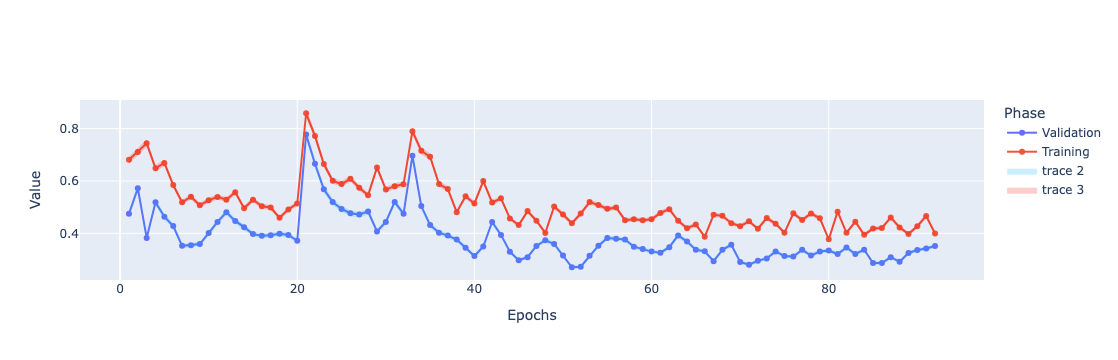

In [31]:
#create_plots1(epochs_train, epochs_valid, epoch_valid_metrics)
#plots(epochs_train, epochs_valid, epoch_valid_metrics)


# In[30]:


import os
import plotly.express as px
import plotly.graph_objects as go

my_model_directory = os.path.join('./', 'Experiments/VGG13_histeq_tff')

y_train = []
with open(os.path.join(my_model_directory, "epochs_train.txt"), "r") as file1:
    for line in file1:
      y_train.append(float(line))


y_valid = []
with open(os.path.join(my_model_directory, "epochs_valid.txt"), "r") as file1:
    for line in file1:
      y_valid.append(float(line))


t = np.linspace(1, len(y_valid), len(y_valid))
x_rev = t[::-1]

valid_scores_mean = np.mean(y_valid)
valid_scores_std = np.std(y_valid)
train_scores_mean = np.mean(y_train)
train_scores_std = np.std(y_train)

ci_valid = []
ci_train = []

for i in range(len(y_valid)):
  ci_valid.append(0.1 * y_valid[i] * valid_scores_std / valid_scores_mean)
  ci_train.append(0.1 * y_train[i] * train_scores_std / train_scores_mean)

fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=y_valid,
                      mode='lines+markers',
                      name='Validation'))
  
fig.add_trace(go.Scatter(x=t, y=y_train,
                      mode='lines+markers',
                      name='Training'))

y_u_valid = []
y_l_valid = []

for i in range(len(y_valid)):
  y_u_valid.append(y_valid[i] + ci_valid[i])
  y_l_valid.append(y_valid[i] - ci_valid[i])
y_l_valid = y_l_valid[::-1]

fig.add_trace(go.Scatter(
  x=np.concatenate([t, x_rev]),
  y=np.concatenate([y_u_valid, y_l_valid]),
  fill='toself',
  fillcolor='rgba(0,176,246,0.2)',
  line_color='rgba(255,255,255,0)', 
))

y_u_train = []
y_l_train = []

for i in range(len(y_train)):
  y_u_train.append(y_train[i] + ci_train[i])
  y_l_train.append(y_train[i] - ci_train[i])
y_l_train = y_l_train[::-1]

fig.add_trace(go.Scatter(
  x=np.concatenate([t, x_rev]),
  y=np.concatenate([y_u_train, y_l_train]),
  fill='toself',
  fillcolor='rgba(255,0,0,0.2)',
  line_color='rgba(255,255,255,0)', 
))

fig.update_layout(legend_title_text = "Phase")
#fig.update_yaxes(type="log", title_text="Log(Value)")
fig.update_xaxes(title_text="Epochs")
fig.update_yaxes(title_text="Value")

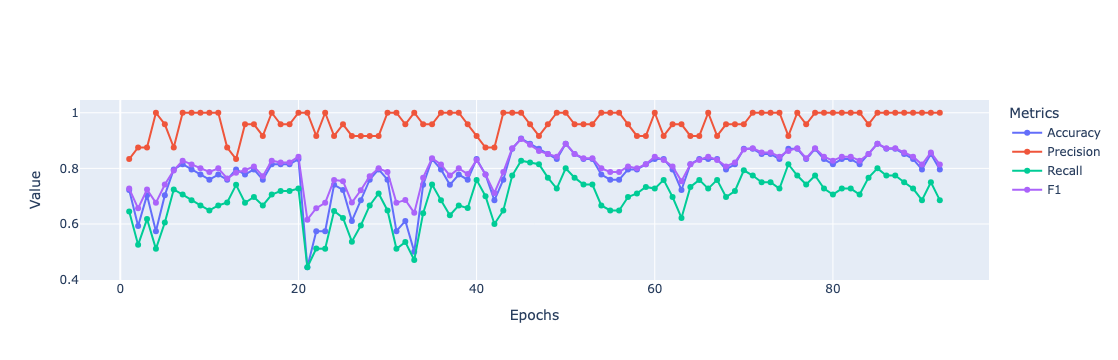

In [32]:

# In[31]:


accuracy = []
precision = []
recall = []
F1 = []

with open(os.path.join(my_model_directory, "epochs_valid_metrics.txt"), "r") as file1:
    for line in file1:
        lst = line.split()
        accuracy.append(float(lst[0]))
        precision.append(float(lst[1]))
        recall.append(float(lst[2]))
        F1.append(float(lst[3]))    


fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=accuracy,
                      mode='lines+markers',
                      name='Accuracy'))

fig.add_trace(go.Scatter(x=t, y=precision,
                      mode='lines+markers',
                      name='Precision'))
  
fig.add_trace(go.Scatter(x=t, y=recall,
                      mode='lines+markers',
                      name='Recall'))
                      
fig.add_trace(go.Scatter(x=t, y=F1,
                    mode='lines+markers',
                    name='F1'))
  
fig.update_layout(legend_title_text = "Metrics")
fig.update_xaxes(title_text="Epochs")
fig.update_yaxes(title_text="Value")

fig.show()


In [ ]:
import os
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

def load_model(model_path):
    return tf.keras.models.load_model(model_path)

def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

def predict_image(model, img_array):
    predictions = model.predict(img_array)
    return predictions

if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("Usage: python predict.py <model_path> <image_path>")
        sys.exit(1)

    model_path = sys.argv[1]
    image_path = sys.argv[2]

    if not os.path.exists(model_path):
        print(f"Model path {model_path} does not exist.")
        sys.exit(1)

    if not os.path.exists(image_path):
        print(f"Image path {image_path} does not exist.")
        sys.exit(1)

    model = load_model(model_path)
    img_array = preprocess_image(image_path, target_size=(224, 224))  # Adjust target_size as needed
    predictions = predict_image(model, img_array)

    print(f"Predictions: {predictions}")